## Copernicus Forecast Handler Module

This is a module to handle seasonal forecast data from the Copernicus Climate Data Store (CDS) in the [U-CLIMADAPT project](https://www.copernicus-user-uptake.eu/user-uptake/details/responding-to-the-impact-of-climate-change-u-climadapt-488). It provides functionality for downloading, processing, calculating climate indices, and creating hazard objects
based on seasonal forecast data, in particular [Seasonal forecast daily and subdaily data on single levels](https://cds.climate.copernicus.eu/datasets/seasonal-original-single-levels?tab=overview). It is designed to work with the CLIMADA (CLIMate ADAptation) platform for climate risk
assessment and adaptation strategies.

Features:
- Download seasonal forecast data from CDS
- Process raw data into climate indices
- Calculate various heat-related indices (e.g., Heat Index, Tropical Nights)
- Create CLIMADA Hazard objects for further risk analysis
- Visualize hazard data

Prerequisites:

1. CDS account and API key:
   Register at https://cds-beta.climate.copernicus.eu

2. CDS API client installation:
   pip install cdsapi

3. CDS API configuration:
   Create a .cdsapirc file in your home directory with your API key and URL.
   For instructions, visit: https://cds-beta.climate.copernicus.eu/how-to-api#install-the-cds-api-client

4. Dataset Terms and Conditions: After selecting the dataset to download, make 
   sure to accept the terms and conditions on the corresponding dataset webpage in the CDS portal before running this notebook. Here, https://cds.climate.copernicus.eu/datasets/seasonal-original-single-levels?tab=download.

Usage:
This module is typically imported and used within larger scripts or applications for climate data processing
and risk assessment. See individual function docstrings for specific usage instructions.

Note:
Ensure you have necessary permissions and comply with CDS data usage policies when using this module.

In [1]:
# Import packages

import warnings
import datetime as dt
warnings.filterwarnings('ignore')
from pathlib import Path

from climada.hazard import Hazard
from climada_petals.hazard.copernicus_forecast.handler import ForecastHandler
from climada.util.constants import SYSTEM_DIR

# Initialize handler
handler = ForecastHandler()

### Set up module parameters

When you are setting up the module to work with Copernicus forecast data and convert it into a hazard object for CLIMADA, you will need to configure a few key parameters. These parameters are essential because they dictate the type of data retrieved, its format, the period, and the geographic focus of the forecast data that will be transformed into a hazard model.

Bellow we describe these parameters and provide an example for the indicator tropical night to exemplify the seasonal forescast handler's funtionality.

To learn more about what these parameters entail and their significance, please refer to the [documentation on the CDS webpage](https://cds-beta.climate.copernicus.eu/datasets/seasonal-original-single-levels?tab=overview).

#### Overview of parameters

**index_metric**: Defines the type of index to be calculated. The current options available are 'HIA' (Heat Index Adjusted), 'HIS' (Heat Index Simplified), 'Tmean' (Mean Temperature), 'HW' (Heat Wave), and 'TR' (Tropical Nights), 'TX30' (HotDays).

**format** : Specifies the format of the data to be downloaded, "grib" or "netcdf". Noted that GRIB files are more complex to process compared to NetCDF.

**originating_centre**: Identifies the source of the data. A standard choice is "dwd" (German Weather Service), one of eight providers including ECMWF, UK Met Office, Météo France, CMCC, NCEP, JMA, and ECCC.

**system**: Refers to a specific model or configuration used for forecasts. In this script, the default value is "21," which corresponds to the GCSF (German Climate Forecast System) [version 2.1](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020MS002101). More details can be found in the [CDS documentation](https://cds-beta.climate.copernicus.eu/datasets/seasonal-original-single-levels?tab=documentation).

**max_lead_month**: Defines the maximum lead time in months for forecast data. For this example we set it to 4 months, meaning forecasts up to four months into the future. The maximum available is 7 months.

**year_list**: A list of years for which data should be downloaded and processed.

**month_list**: Starting months for seasonal forecast data. [6, 7] means data starts from June and July.

**area_selection**: This determines the geographical area for which the data should be downloaded. It can be set to
- "global" (gobal data is downloaded)
- a list of ISO alpha-3 codes for different countries, e.g., ["DEU", "CHE"] for Germany and Switzerland. See this [wikipedia page](https://en.wikipedia.org/wiki/ISO_3166-1_alpha-3) for the country codes. Note that the **joint region** will be downloaded and processed, i.e., handling data for ["DEU", "CHE"] and then for ["CHE"] will download and generate two sets of data.
- a list of four numbers corresponding to the geographical bounds (in degrees; EPSG:4326), specified as [north, west, south, east]. 

**overwrite**: Boolean flag that, when set to True, forces the system to redownload and reprocess existing files.


** TO DO : Ensure the code runs on different platforms (Linux, Windows, macOS).**

In [2]:
# We define above parameters for an example 
index_metric = "TR" # tropical nights
format = "grib"  # 'grib' or 'netcdf'
originating_centre =  "dwd"
system =  "21" 
max_lead_month = 4
year_list = [2018] 
month_list = [9]
area_selection = ['DEU', 'CHE']  
overwrite = False

# Details on the characteristics of the selected indicator and the input data used
handler.explain_index(index_metric)

Explanation for 'TR': Tropical Nights: This indicator counts the number of nights where the minimum temperature remains above a certain threshold, typically 20°C.
Required Input Data: ['2m temperature (t2m)']


### Download and Process Data

The `handler.download_and_process_data` method in CLIMADA efficiently retrieves and organizes Copernicus forecast data. It checks for existing files to avoid redundant downloads, stores data by format (grib or netCDF), year, month. Then the files are processed for further analysis, such as calculating climate indices or creating hazard objects within CLIMADA. Here are the aspects of this process:

- **Data Download**: The method downloads the forecast data for the selected years, months, and regions. The data is retrieved in **grib** or **netCDF** formats, which are commonly used for storing meteorological data. If the required files already exist in the specified directories, the system will skip downloading them, as indicated by the log messages such as:  
  *"Corresponding grib file SYSTEM_DIR/copernicus_forecast/input_data/dwd/grib/2022/06/t2m_area-16_63_47_4_202206.grib already exists."*

- **Data Processing**: After downloading (or confirming the existence of) the files, the system converts them into daily **netCDF** files. This format suseful for working with multi-dimensional climate data. The log messages confirm the existence or creation of these files, for example:  
  *"Daily file SYSTEM_DIR/copernicus_forecast/input_data/netcdf/daily/dwd/2022/06/t2m_area-16_63_47_4_202206.nc already exists."*

- **Geographic and Temporal Focus**: The files are generated for a specific time frame (e.g., June and July 2022) and a predefined geographic region, as specified by the parameters such as `area_selection`, `month_list`, and `year_list`. This ensures that only the selected data for your analysis is downloaded and processed.

- **Data Completeness**: Messages like "already exists" ensure that you do not redundantly download or process data, saving time and computing resources. However, if the data files are missing, they will be downloaded and processed as necessary.

In [3]:
# Download and process data
handler.download_and_process_data(index_metric, year_list, month_list, area_selection, overwrite, format, originating_centre, system, max_lead_month)

2024-10-28 14:39:23,624 | WARNING : Before downloading, please ensure you have reviewed and accepted the terms and conditions for the use of this dataset. Access the terms here: https://cds.climate.copernicus.eu/datasets/seasonal-original-single-levels?tab=download
2024-10-28 14:39:23,626 | INFO : 489 leadtimes to download.
2024-10-28 14:39:23,880 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2024-10-28 14:39:23,880 | INFO : [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[

### Calculate Climate Indices

When you use the `handler.calculate_index` method in CLIMADA to compute specific climate indices (such as Tropical Nights), the generated output is saved and organized in a structured format for further analysis. Here some details:

- **Index Calculation**: The method processes seasonal forecast data to compute the selected index for the chosen years, months, and regions. This index represents a specific climate condition, such as the number of Tropical Nights ("TR") over the forecast period, as defined in the parameters.

- **Data Storage**: The calculated index data is saved in **netCDF** format. These files are automatically saved in directories specific to the index and time period. The file paths are printed below the processing steps. For example, the computed index values are stored in:  
  *"SYSTEM_DIR/copernicus_forecast/indices/dwd/TR/2022/06/TR_area4_56_45_16_202206.nc"*

  Similarly, the statistics of the index (e.g., mean, max, min, std) are saved in:  
  *"SYSTEM_DIR/copernicus_forecast/indices/dwd/TR/2022/06/stats/stats_TR_area4_56_45_16_202206.nc"*.  
  These files ensure that both the raw indices and their statistical summaries are available for detailed analysis.
  
  Each file contains data for a specific month and geographic region, as defined in the parameters. This allows you to analyze how the selected climate index varies over time and across different locations.

- **Completeness of Data Processing**: Messages 'Index TR successfully calculated and saved for...' confirm the successful calculation and storage of the index, ensuring that all requested data has been processed and saved correctly.


In [4]:
# Calculate index
handler.calculate_index(index_metric, year_list, month_list, area_selection, overwrite, originating_centre)

2024-10-28 14:41:40,874 | INFO : Writing index data to /Users/daraya/climada/data/copernicus_forecast/indices/dwd/TR/2018/09/TR_dwd_area4_56_45_16_201809.nc.
2024-10-28 14:41:40,889 | INFO : Index TR successfully calculated and saved for 2018-09.


Data saved at:
- Monthly index: /Users/daraya/climada/data/copernicus_forecast/indices/dwd/TR/2018/09/TR_dwd_area4_56_45_16_201809.nc
- Statistics: /Users/daraya/climada/data/copernicus_forecast/indices/dwd/TR/2018/09/stats/stats_TR_dwd_area4_56_45_16_201809.nc


### Calculate a Hazard Object

When you use the `handler.process_and_save_hazards` method in CLIMADA to convert processed index from Copernicus forecast data into a hazard object:

- **Hazard Object Creation**: The method processes seasonal forecast data for specified years and months, converting these into hazard objects. These objects encapsulate potential risks associated with specific weather events or conditions, such as Tropical Nights ('TR') indicated in the parameters, over the forecast period.

- **Data Storage**: The hazard data for each ensemble member of the forecast is saved as HDF5 files. These files are automatically stored in specific directories corresponding to each month and type of hazard. The file paths are printed below the processing steps. For example, *"/SYSTEM_DIR/copernicus_forecast/hazard/dwd/TR/2022/06/hazard_TR_area4_56_45_16_202207.hdf5"*
 HDF5 is a versatile data model that efficiently stores large volumes of complex data.
 
 Each file is specific to a particular month and hazard scenario ('TR' in this case) and covers all ensemble members for that forecast period, aiding in detailed risk analysis.

- **Completeness of Data Processing**: Messages like 'Completed processing for 2022-07. Data saved in...' confirm the successful processing and storage of the hazard data for that period, ensuring that all requested data has been properly handled and stored.

#### Visualizing the Calculated Hazard Object

Once the hazard object has been successfully calculated, the last element created is printed for visualization. This is important for several reasons:

- **Initial Data Inspection**: The visualization allows you to view a slice of the forecast data, providing a quick check of the results. This initial glimpse helps you verify that the data processing was successful and provides insights into the distribution of the hazard (in this case, Tropical Nights) across the area of interest.

- **Geographic Accuracy**: The map helps you verify if the correct geographic region was processed and plotted. This is particularly useful as it allows immediate feedback on whether the user-defined boundaries or selected areas (e.g., Germany and Switzerland) were captured correctly.

- **Data Quality Check**: Visualizing the output also serves as a preliminary quality check, allowing you to detect any unexpected results or anomalies in the data. For instance, the color bar indicating the "Intensity (days)" gives an indication of how the hazard index is distributed across the mapped area.

- **Quick Workflow Testing**: This step is essential for testing the entire workflow, ensuring that the process is working as expected from data download, processing, and hazard object creation to visualization.

This output provides a structured dataset ready for further analysis within the CLIMADA framework, allowing for the evaluation of potential impacts and the planning of mitigation strategies. 


2024-10-28 14:41:43,988 - climada.hazard.io - INFO - Writing /Users/daraya/climada/data/copernicus_forecast/hazard/dwd/TR/2018/09/hazard_TR_dwd_area4_56_45_16_201809.hdf5
2024-10-28 14:41:44,005 - climada.hazard.centroids.centr - INFO - Writing /Users/daraya/climada/data/copernicus_forecast/hazard/dwd/TR/2018/09/hazard_TR_dwd_area4_56_45_16_201809.hdf5
Completed processing for 2018-09. Data saved in /Users/daraya/climada/data/copernicus_forecast/hazard/dwd/TR/2018/09.
2024-10-28 14:41:44,055 - climada.hazard.io - INFO - Reading /Users/daraya/climada/data/copernicus_forecast/hazard/dwd/TR/2018/09/hazard_TR_dwd_area4_56_45_16_201809.hdf5


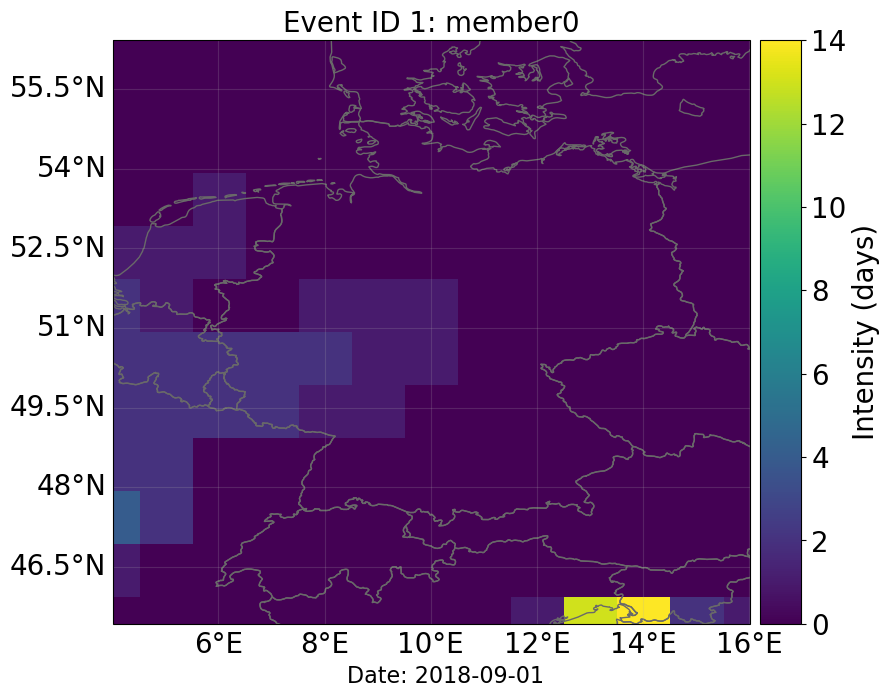

In [5]:
handler.save_index_to_hazard(index_metric, year_list, month_list, area_selection, overwrite, originating_centre)

## Example for reading and plotting hazard

The saved hazard file can then be read and processed by standard CLIMADA methods. For instance, below, we load the hazard for the last month and plot the intensity per grid point maximized over all forecast ensemble members.

2024-10-28 14:41:48,784 - climada.hazard.io - INFO - Reading /Users/daraya/climada/data/copernicus_forecast/hazard/dwd/TR/2018/09/hazard_TR_dwd_area4_56_45_16_201809.hdf5


<GeoAxes: title={'center': 'TR max intensity at each point'}>

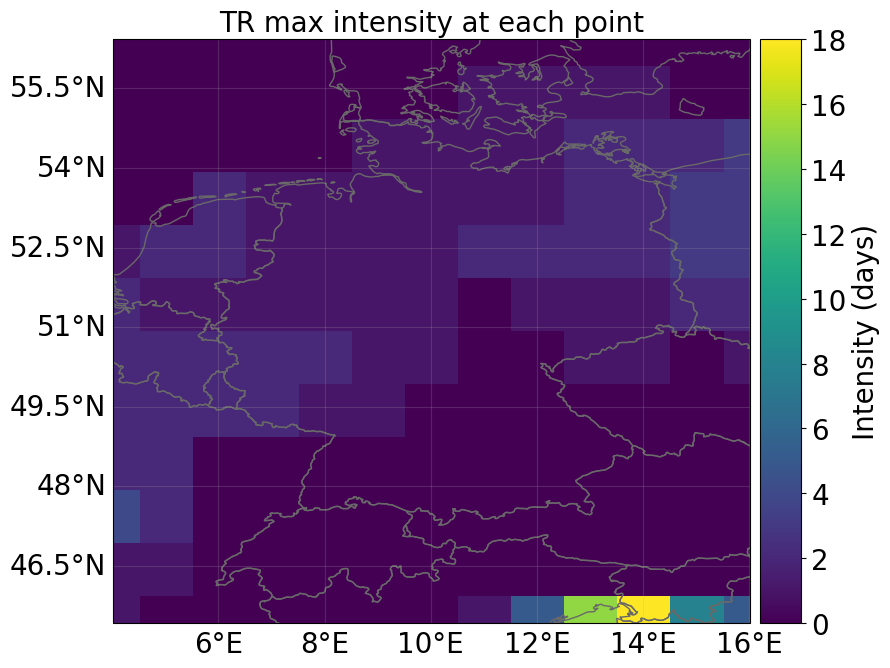

In [6]:
# Choose the example hazard
year = year_list[-1]  # Retrieve the last year in the list for the example
month = month_list[-1]  # Retrieve the last month in the list for the example
ordinal_date = dt.datetime.fromisoformat(f"{year}-{month:02d}-01").toordinal()  # Convert date to ordinal format
bounds = handler._get_bounds_for_area_selection(area_selection)  # Get bounds for the area selection
area_str = f"area{int(bounds[1])}_{int(bounds[0])}_{int(bounds[2])}_{int(bounds[3])}"

# Define the correct hazard directory and path
hazard_directory = f"{handler.data_out}/hazard/{originating_centre}/{index_metric}/{year}/{month:02d}"  
hazard_path = f"{hazard_directory}/hazard_{index_metric}_{originating_centre}_{area_str}_{year}{month:02d}.hdf5" 

# Load the hazard and plot intensity for the selected grid, maximized over ensemble
haz = Hazard.from_hdf5(hazard_path)  # Load the hazard object from the defined path
haz.select(date=[ordinal_date, ordinal_date]).plot_intensity(event=0, smooth=False)  # Plot intensity for the selected event


In [7]:
file_path = '/Users/daraya/climada/data/copernicus_forecast/hazard/dwd/TR/2024/07/hazard_TR_dwd_area4_56_45_16_202407.hdf5'
haz = Hazard.from_hdf5(file_path)  # Pass the single file path, not a list
print(haz.event_name)  # Access the event name attribute



2024-10-28 14:41:50,434 - climada.hazard.io - INFO - Reading /Users/daraya/climada/data/copernicus_forecast/hazard/dwd/TR/2024/07/hazard_TR_dwd_area4_56_45_16_202407.hdf5
['member0', 'member0', 'member0', 'member0', 'member1', 'member1', 'member1', 'member1', 'member2', 'member2', 'member2', 'member2', 'member3', 'member3', 'member3', 'member3', 'member4', 'member4', 'member4', 'member4', 'member5', 'member5', 'member5', 'member5', 'member6', 'member6', 'member6', 'member6', 'member7', 'member7', 'member7', 'member7', 'member8', 'member8', 'member8', 'member8', 'member9', 'member9', 'member9', 'member9', 'member10', 'member10', 'member10', 'member10', 'member11', 'member11', 'member11', 'member11', 'member12', 'member12', 'member12', 'member12', 'member13', 'member13', 'member13', 'member13', 'member14', 'member14', 'member14', 'member14', 'member15', 'member15', 'member15', 'member15', 'member16', 'member16', 'member16', 'member16', 'member17', 'member17', 'member17', 'member17', 'mem

2024-10-28 14:41:50,454 - climada.hazard.io - INFO - Reading /Users/daraya/climada/data/copernicus_forecast/hazard/dwd/TR/2024/07/hazard_TR_dwd_area4_56_45_16_202407.hdf5
The date of hazard event 1: 2024-07-01 00:00:00
The date of hazard event 2: 2024-08-01 00:00:00
The date of hazard event 3: 2024-09-01 00:00:00
The date of hazard event 4: 2024-10-01 00:00:00
The date of hazard event 5: 2024-07-01 00:00:00
The date of hazard event 6: 2024-08-01 00:00:00
The date of hazard event 7: 2024-09-01 00:00:00
The date of hazard event 8: 2024-10-01 00:00:00
The date of hazard event 9: 2024-07-01 00:00:00
The date of hazard event 10: 2024-08-01 00:00:00
The date of hazard event 11: 2024-09-01 00:00:00
The date of hazard event 12: 2024-10-01 00:00:00
The date of hazard event 13: 2024-07-01 00:00:00
The date of hazard event 14: 2024-08-01 00:00:00
The date of hazard event 15: 2024-09-01 00:00:00
The date of hazard event 16: 2024-10-01 00:00:00
The date of hazard event 17: 2024-07-01 00:00:00
The d

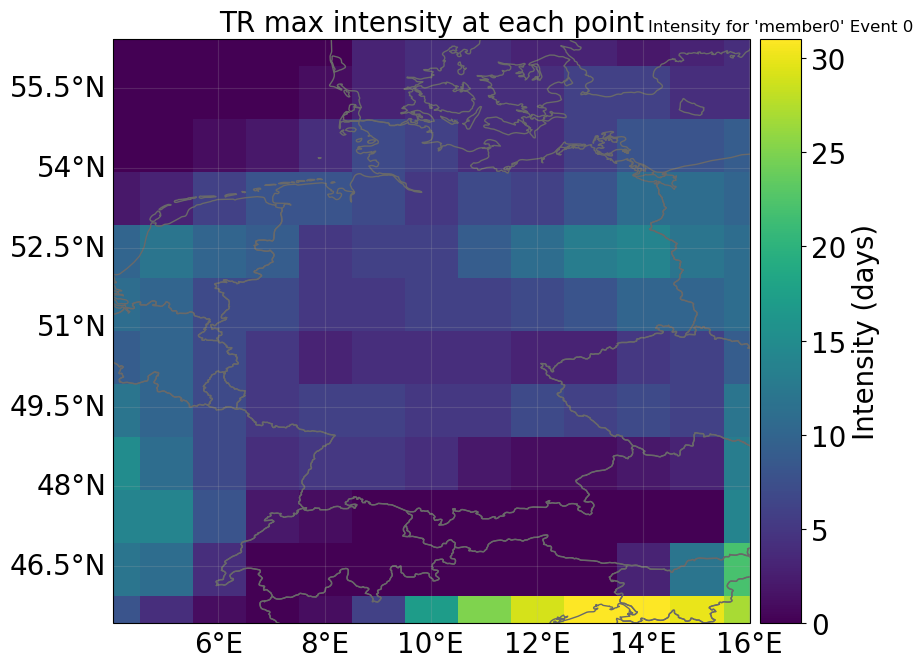

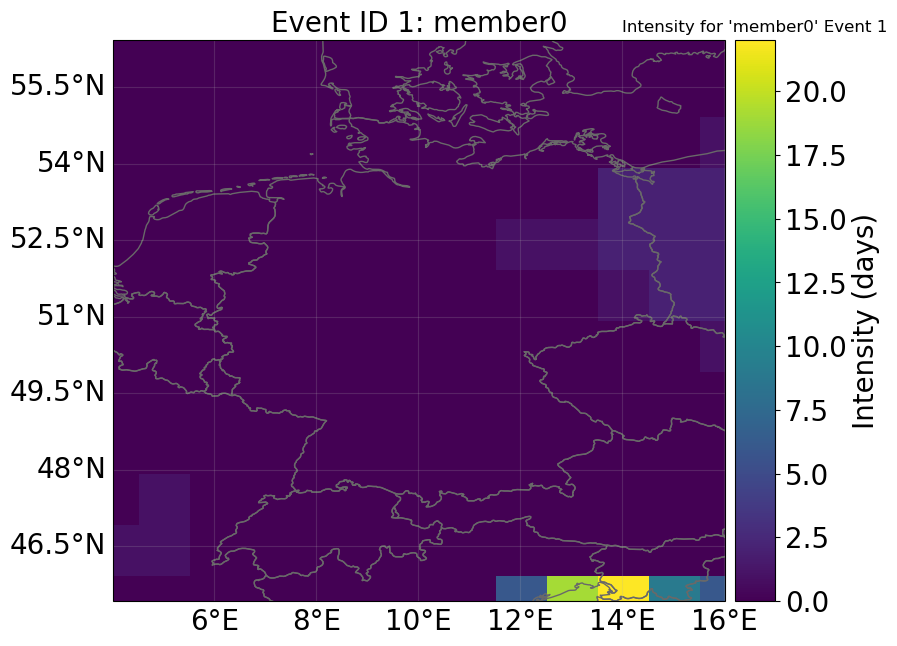

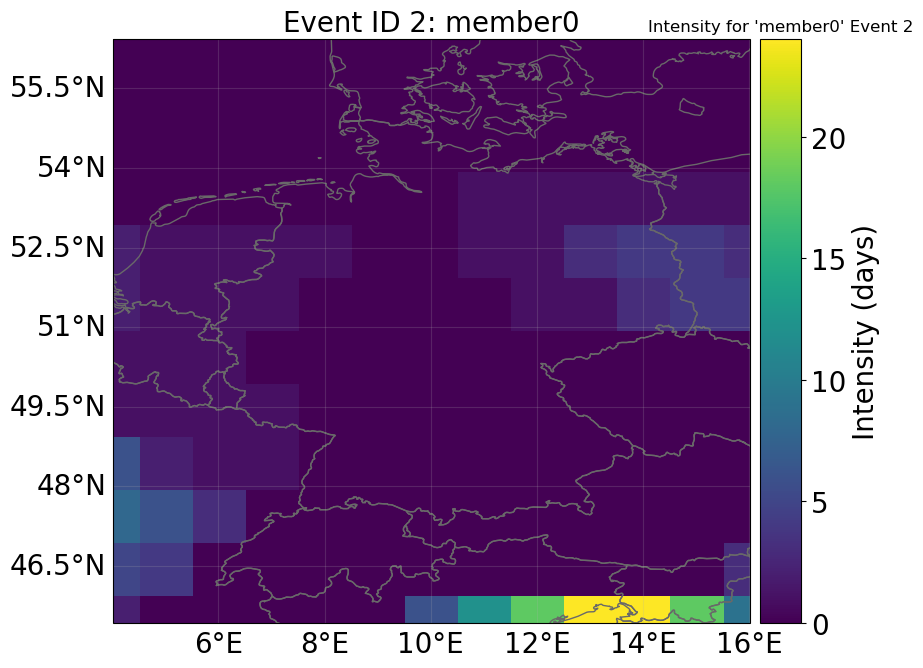

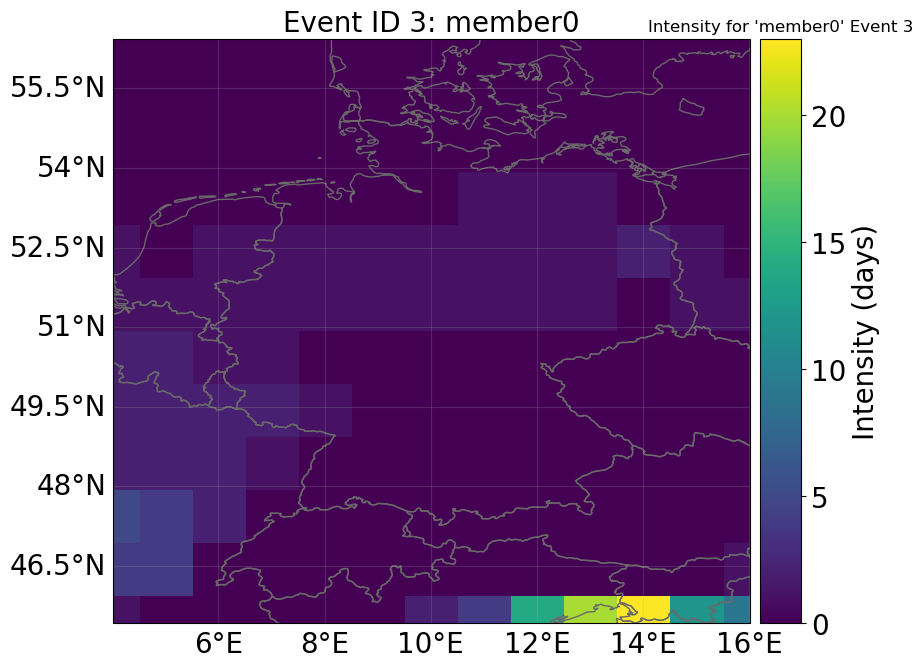

In [8]:
import matplotlib.pyplot as plt
from climada.hazard import Hazard

# File path to the hazard data
file_path = '/Users/daraya/climada/data/copernicus_forecast/hazard/dwd/TR/2024/07/hazard_TR_dwd_area4_56_45_16_202407.hdf5'

# Load the hazard data
haz = Hazard.from_hdf5(file_path)

# Filter for events that are 'member0'
member0_events = [i for i, name in enumerate(haz.event_name) if name == 'member0']

# Access the dates of the hazard events (in ordinal format)
hazard_dates = haz.date

# Loop through each ordinal date and convert to datetime
for i, ordinal_date in enumerate(hazard_dates):
    specific_date = dt.datetime.fromordinal(ordinal_date)
    print(f"The date of hazard event {i+1}: {specific_date}")

# Loop through and plot each 'member0' event
for event_id in member0_events:
    # Plot intensity for each 'member0' event
    haz.plot_intensity(event=event_id, smooth=False)
    
    # Optional: Add a title for each plot
    plt.title(f"Intensity for 'member0' Event {event_id}")
    plt.show()


2024-10-28 14:41:56,618 - climada.hazard.io - INFO - Reading /Users/daraya/climada/data/copernicus_forecast/hazard/dwd/TR/2024/07/hazard_TR_dwd_area4_56_45_16_202407.hdf5


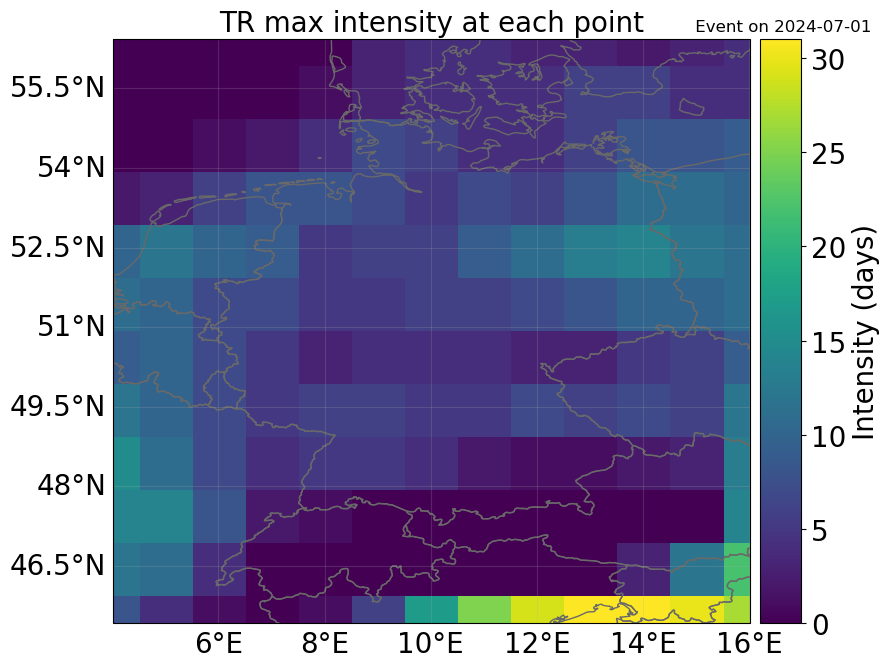

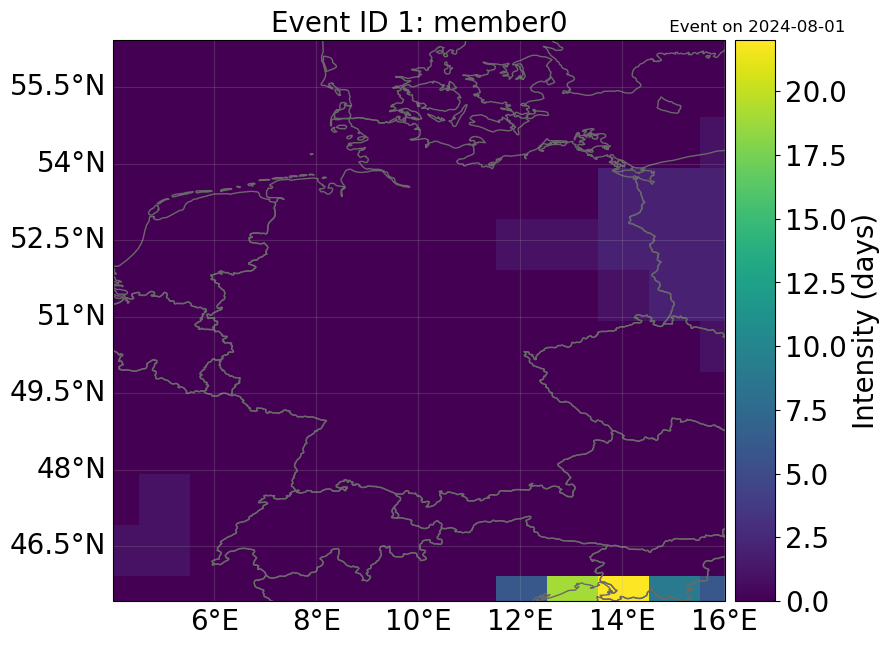

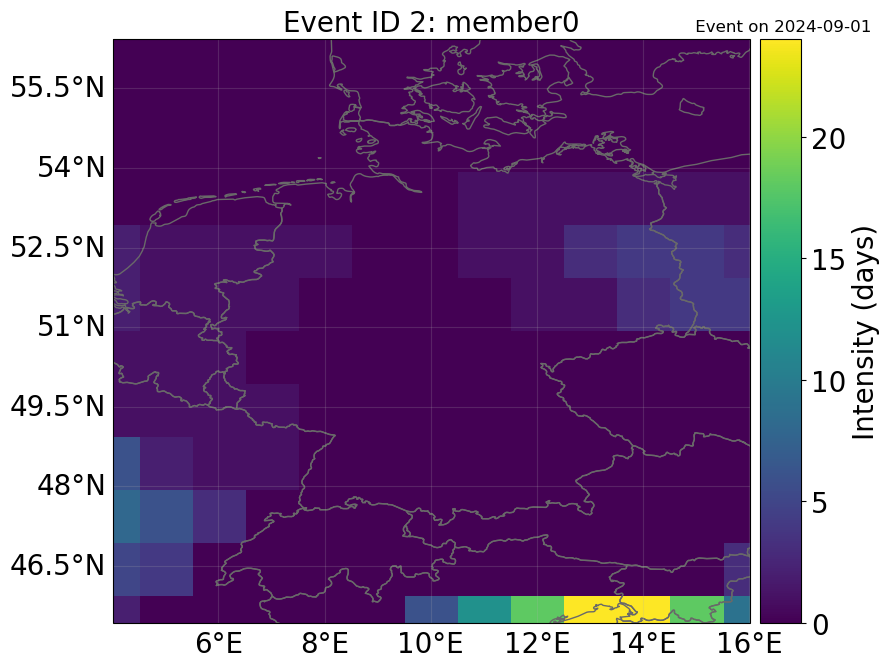

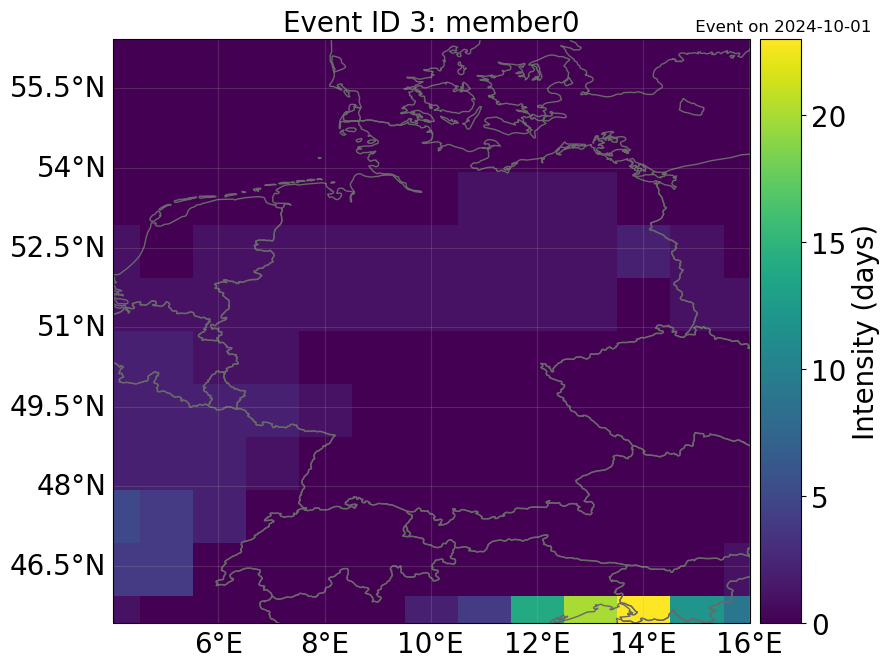

In [9]:
import matplotlib.pyplot as plt
import datetime as dt
from climada.hazard import Hazard

# File path to the hazard data
file_path = '/Users/daraya/climada/data/copernicus_forecast/hazard/dwd/TR/2024/07/hazard_TR_dwd_area4_56_45_16_202407.hdf5'

# Load the hazard data
haz = Hazard.from_hdf5(file_path)

# Filter for events that are 'member0'
member0_events = [i for i, name in enumerate(haz.event_name) if name == 'member0']

# Access the dates of the hazard events (in ordinal format)
hazard_dates = haz.date

# Loop through and plot each 'member0' event
for event_id in member0_events:
    # Get the corresponding date for this event
    specific_date = dt.datetime.fromordinal(hazard_dates[event_id])
    
    # Plot intensity for each 'member0' event (the default title will be replaced by plt.title())
    haz.plot_intensity(event=event_id, smooth=False)
    
    # Add a custom title, which will overwrite the default title
    plt.title(f" Event on {specific_date.strftime('%Y-%m-%d')}")
    
    # Show the plot with the custom title
    plt.show()



In [10]:
import matplotlib.pyplot as plt
import numpy as np
from climada.hazard import Hazard
import datetime as dt

# File path to the hazard data
file_path = '/Users/daraya/climada/data/copernicus_forecast/hazard/dwd/TR/2024/07/hazard_TR_dwd_area4_56_45_16_202407.hdf5'

# Load the hazard data
haz = Hazard.from_hdf5(file_path)

# Get the unique members from the event names
unique_members = list(set(haz.event_name))  # This should give you ['member0', 'member1', ..., 'memberN']

# Initialize an array to store the cumulative intensities
mean_intensity = np.zeros(haz.intensity.shape[1])  # Assume shape[1] is for locations

# Count of events per month (assuming all events for a member belong to the same month)
count_members = 0

# Loop through all events and sum intensities for each member
for member in unique_members:
    # Filter events for this member
    member_events = [i for i, name in enumerate(haz.event_name) if name == member]
    
    # Sum the intensity of all events for the member
    for event_id in member_events:
        mean_intensity += haz.intensity[event_id]
        count_members += 1

# Compute the mean intensity by dividing by the number of members
mean_intensity /= count_members

# Plot the mean intensity
haz.plot_intensity(event=None, smooth=False)
plt.title(f"Mean Intensity Across All Members for {specific_date.strftime('%Y-%m')}")
plt.show()



2024-10-28 14:42:02,731 - climada.hazard.io - INFO - Reading /Users/daraya/climada/data/copernicus_forecast/hazard/dwd/TR/2024/07/hazard_TR_dwd_area4_56_45_16_202407.hdf5


ValueError: Provide one event id or one centroid id.

In [ ]:
import xarray as xr

# Load the NetCDF file using xarray
file_path = '/Users/daraya/climada/data/copernicus_forecast/indices/dwd/TR/2024/07/TR_dwd_area4_56_45_16_202407.nc'
ds = xr.open_dataset(file_path)

ds


<xarray.Dataset> Size: 250kB
Dimensions:    (number: 50, latitude: 12, longitude: 13, step: 4)
Coordinates:
  * number     (number) int64 400B 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49
  * latitude   (latitude) float64 96B 56.42 55.42 54.42 ... 47.42 46.42 45.42
  * longitude  (longitude) float64 104B 4.018 5.018 6.018 ... 14.02 15.02 16.02
    time       datetime64[ns] 8B ...
    surface    float64 8B ...
  * step       (step) <U7 112B '2024-07' '2024-08' '2024-09' '2024-10'
Data variables:
    TR         (number, step, latitude, longitude) int64 250kB ...

In [ ]:


# Load the NetCDF file using xarray
file_path = '/Users/daraya/climada/data/copernicus_forecast/input_data/netcdf/daily/dwd/2024/06/dwd_t2m_area4_56_45_16_202406.nc'
ds = xr.open_dataset(file_path)

ds

<xarray.Dataset> Size: 11MB
Dimensions:     (number: 50, step: 122, latitude: 12, longitude: 13)
Coordinates:
  * number      (number) int64 400B 0 1 2 3 4 5 6 7 ... 42 43 44 45 46 47 48 49
    time        datetime64[ns] 8B ...
  * step        (step) timedelta64[ns] 976B 0 days 15:00:00 ... 121 days 15:0...
    surface     float64 8B ...
  * latitude    (latitude) float64 96B 56.42 55.42 54.42 ... 47.42 46.42 45.42
  * longitude   (longitude) float64 104B 4.018 5.018 6.018 ... 14.02 15.02 16.02
    valid_time  (step) datetime64[ns] 976B ...
Data variables:
    t2m_mean    (number, step, latitude, longitude) float32 4MB ...
    t2m_max     (number, step, latitude, longitude) float32 4MB ...
    t2m_min     (number, step, latitude, longitude) float32 4MB ...

In [ ]:
import xarray as xr

# File path to the GRIB file
file_path = '/Users/daraya/climada/data/copernicus_forecast/input_data/grib/2024/06/ukmo_t2m_area4_56_45_16_202406.grib'

# Open the GRIB file using xarray with the cfgrib engine
ds = xr.open_dataset(file_path, engine='cfgrib')

ds

<xarray.Dataset> Size: 617kB
Dimensions:     (number: 2, step: 488, latitude: 12, longitude: 13)
Coordinates:
  * number      (number) int64 16B 1 2
    time        datetime64[ns] 8B ...
  * step        (step) timedelta64[ns] 4kB 0 days 06:00:00 ... 122 days 00:00:00
    surface     float64 8B ...
  * latitude    (latitude) float64 96B 56.42 55.42 54.42 ... 47.42 46.42 45.42
  * longitude   (longitude) float64 104B 4.018 5.018 6.018 ... 14.02 15.02 16.02
    valid_time  (step) datetime64[ns] 4kB ...
Data variables:
    t2m         (number, step, latitude, longitude) float32 609kB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             egrr
    GRIB_centreDescription:  U.K. Met Office - Exeter
    GRIB_subCentre:          98
    Conventions:             CF-1.7
    institution:             U.K. Met Office - Exeter
    history:                 2024-10-15T17:15 GRIB to CDM+CF via cfgrib-0.9.9...

In [ ]:
import xarray as xr

# File path to the GRIB file
file_path = '/Users/daraya/climada/data/copernicus_forecast/input_data/dwd/grib/2024/07/dwd_t2m_area4_56_45_16_202407.grib'

# Open the GRIB file using xarray with the cfgrib engine
ds = xr.open_dataset(file_path, engine='cfgrib')


ds

<xarray.Dataset> Size: 15MB
Dimensions:     (number: 50, step: 492, latitude: 12, longitude: 13)
Coordinates:
  * number      (number) int64 400B 0 1 2 3 4 5 6 7 ... 42 43 44 45 46 47 48 49
    time        datetime64[ns] 8B ...
  * step        (step) timedelta64[ns] 4kB 0 days 06:00:00 ... 123 days 00:00:00
    surface     float64 8B ...
  * latitude    (latitude) float64 96B 56.42 55.42 54.42 ... 47.42 46.42 45.42
  * longitude   (longitude) float64 104B 4.018 5.018 6.018 ... 14.02 15.02 16.02
    valid_time  (step) datetime64[ns] 4kB ...
Data variables:
    t2m         (number, step, latitude, longitude) float32 15MB ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             edzw
    GRIB_centreDescription:  Offenbach
    GRIB_subCentre:          98
    Conventions:             CF-1.7
    institution:             Offenbach
    history:                 2024-10-21T16:32 GRIB to CDM+CF via cfgrib-0.9.9...